In [1]:
import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=cuda%d"%(1)
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import pickle, random, sys, keras

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Neha Maiya\AppData\Roaming\Python\Python37\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None
Using Theano backend.


In [2]:
def to_onehot(yin):
    yy = list(yin) # This is a workaround as the map output for python3 is not a list
    yy1 = np.zeros([len(list(yy)), max(yy)+1])
    yy1[np.arange(len(list(yy))),yy] = 1
    return yy1

In [3]:
def ModCls_loaddata(path_to_dataset):
#Usint the function so when the code is run multiple times, the raw input does not run out
    with open(path_to_dataset, 'rb') as open_file:
        u = pickle._Unpickler( open_file )
        u.encoding = 'latin1'
        Xd = u.load()
    
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    X = []  
    lbl = []
    for mod in mods:
        for snr in snrs:
            X.append(Xd[(mod,snr)])
            for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
    X = np.vstack(X)
    
    # Partition the data into training and test sets of the form we can train/test on 
    #  while keeping SNR and Mod labels handy for each
    np.random.seed(2016)
    n_examples = X.shape[0]
    n_train = int(n_examples * 0.5)
    train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
    test_idx = list(set(range(0,n_examples))-set(train_idx))
    X_train = X[train_idx]
    X_test =  X[test_idx]
    
    Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
    Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))
    
    in_shp = list(X_train.shape[1:])
    classes = mods
    return X,lbl,X_train,X_test,classes,snrs,mods,Y_train,Y_test,train_idx,test_idx

In [4]:
X,lbl,X_train,X_test,classes,snrs,mods,Y_train,Y_test,train_idx,test_idx = ModCls_loaddata(
    'C:/Users/Neha Maiya/Documents/Masters Courses/CSC_275/RML2016.10a_dict.pkl')


print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print(X.shape)
print(len(lbl))



print('Y_train[:9]: \n', Y_train[4:9])
print('train_idx.shape:', train_idx.shape)
print('train_idx[4:9]:', train_idx[4:9])
print(lbl[train_idx[4]], lbl[train_idx[5]], lbl[train_idx[6]], lbl[train_idx[7]], lbl[train_idx[8]], lbl[train_idx[9]])

print('classes:', classes)

X_train.shape: (110000, 2, 128)
Y_train.shape: (110000, 11)
(220000, 2, 128)
220000
Y_train[:9]: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
train_idx.shape: (110000,)
train_idx[4:9]: [184829 192624 169402 179790 145554]
('QPSK', -12) ('QPSK', 4) ('QAM64', -2) ('QAM64', 18) ('QAM16', -10) ('BPSK', -2)
classes: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [5]:
in_shp = list(X_train.shape[1:])
print( X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


tf.__version__
tf.test.gpu_device_name()

''

In [8]:
# #build cnn model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , Reshape , ZeroPadding2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# dr = 0.3 # dropout rate (%)

# model = Sequential()

# model.add(Reshape([1]+in_shp, input_shape=in_shp))                                                  #reshape output to [1,2,128]
# model.add(ZeroPadding2D((0, 2)))
# model.add(Conv2D(64, (1, 3),  activation="relu", name="conv1",data_format='channels_first'))
# model.add(MaxPooling2D(pool_size=(1,16), padding="same",data_format="channels_first"))
# model.add(Dropout(dr))                                                                              # helps prevent overfitting by setting a number of i/ps to 0
# model.add(ZeroPadding2D((0, 2)))
# model.add(Conv2D(16, (2, 3),  activation="relu", name="conv2",data_format='channels_first'))
# model.add(Dropout(dr))
# model.add(Flatten())                                                                                #transition from conv to dense, must flatten
# model.add(Dense(126, activation='relu', name="dense1"))                                             #output = activation(dot(input, kernel) + bias)
# model.add(Dropout(dr))
# model.add(Dense(len(classes), name="dense2" ))
# model.add(Activation('softmax'))
# model.add(Reshape([len(classes)]))
# model.compile(loss="categorical_crossentropy", optimizer='adam')
# model.summary()
dr = 0.3 # dropout rate (%)
model = tf.keras.models.Sequential()

model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(Conv2D(padding="same", filters=512, kernel_size=(2,4), kernel_initializer="glorot_uniform", name="conv1", activation="relu", data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(1,16), padding="same",data_format="channels_first"))
model.add(Dropout(dr))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dense(140, activation='relu', kernel_initializer='he_normal', name="dense2"))
model.add(Dense(30, activation='relu', kernel_initializer='he_normal', name="dense3"))

model.add(Dense(len(classes), kernel_initializer='he_normal', name="dense4" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 512, 2, 128)       4608      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 512, 2, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 2, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense1 (Dense)               (None, 256)               2097408   
_________________________________________________________________
dense2 (Dense)               (None, 140)              

In [9]:
import h5py #creating a new file to save the epochs

In [10]:
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  
filepath = "C:/Users/Neha Maiya/Documents/Masters Courses/CSC275/model5.h5"

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
    ]
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
#     verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = callbacks)
model.load_weights(filepath)


Train on 110000 samples, validate on 110000 samples
Epoch 1/100
110000/110000 [==============================] - 249s 2ms/sample - loss: 2.2564 - accuracy: 0.1505 - val_loss: 2.1781 - val_accuracy: 0.1589
Epoch 2/100
110000/110000 [==============================] - 196s 2ms/sample - loss: 2.0623 - accuracy: 0.2216 - val_loss: 1.9708 - val_accuracy: 0.2652
Epoch 3/100
110000/110000 [==============================] - 194s 2ms/sample - loss: 1.9324 - accuracy: 0.2761 - val_loss: 1.9248 - val_accuracy: 0.2693
Epoch 4/100
110000/110000 [==============================] - 196s 2ms/sample - loss: 1.8643 - accuracy: 0.3067 - val_loss: 1.8213 - val_accuracy: 0.3217
Epoch 5/100
110000/110000 [==============================] - 192s 2ms/sample - loss: 1.8057 - accuracy: 0.3305 - val_loss: 1.7688 - val_accuracy: 0.3461
Epoch 6/100
110000/110000 [==============================] - 196s 2ms/sample - loss: 1.7506 - accuracy: 0.3472 - val_loss: 1.7013 - val_accuracy: 0.3722
Epoch 7/100
110000/110000 [===

In [12]:
batch_size=1024
score = model.evaluate(X_test, Y_test,verbose=0, batch_size=batch_size)
print(score)

[1.2904569345300847, 0.49449092]


In [13]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix!!!', cmap=plt.cm.PuBuGn, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

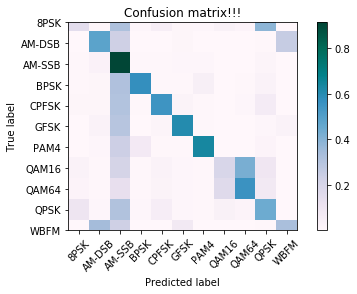

In [14]:
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)


snr -20
Accuracy:  0.09661482159194877
snr -18
Accuracy:  0.09482288828337875
snr -16
Accuracy:  0.10039797395079594
snr -14
Accuracy:  0.11060988812702996
snr -12
Accuracy:  0.14694621695533272
snr -10
Accuracy:  0.20703749777856761
snr -8
Accuracy:  0.27595076244717986
snr -6
Accuracy:  0.4499633431085044
snr -4
Accuracy:  0.5615526802218115
snr -2
Accuracy:  0.6286284470246735
snr 0
Accuracy:  0.6812043795620438
snr 2
Accuracy:  0.6902944383860414
snr 4
Accuracy:  0.7138399412628488
snr 6
Accuracy:  0.7312274368231046
snr 8
Accuracy:  0.7307484220018035
snr 10
Accuracy:  0.7364298724954462
snr 12
Accuracy:  0.7352887923230128
snr 14
Accuracy:  0.7313157409116073
snr 16
Accuracy:  0.7330316742081447
snr 18
Accuracy:  0.738973897389739


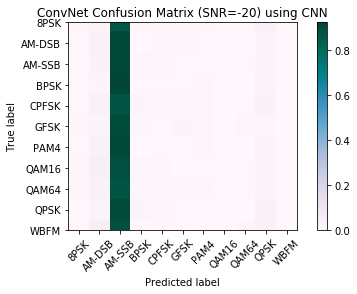

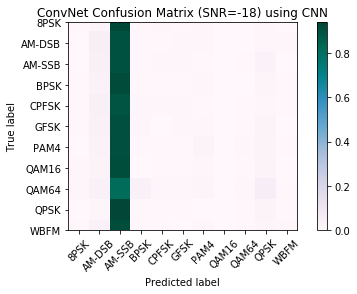

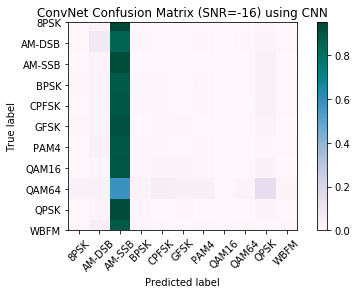

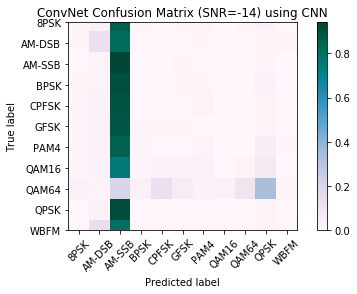

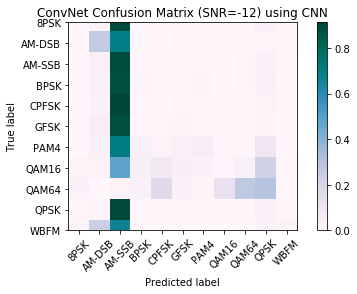

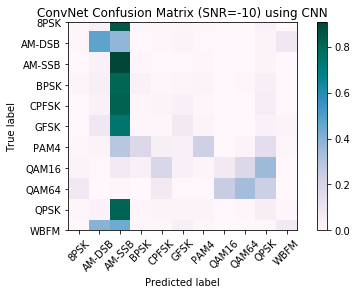

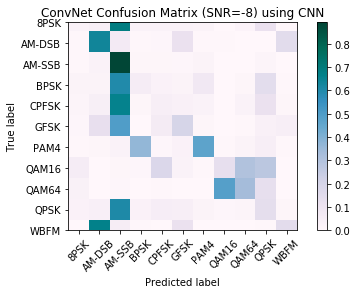

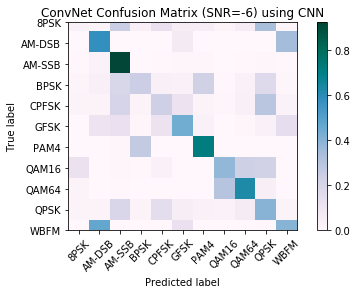

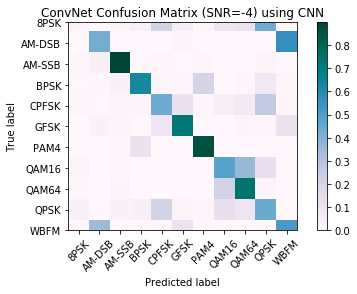

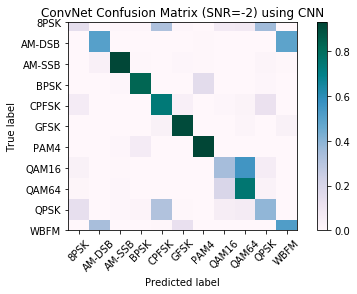

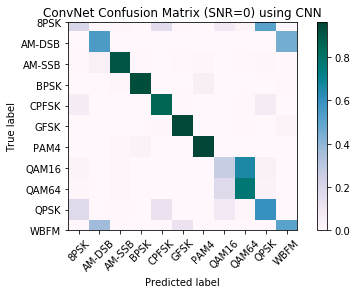

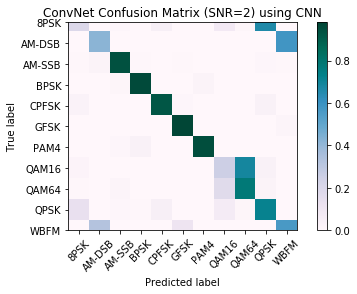

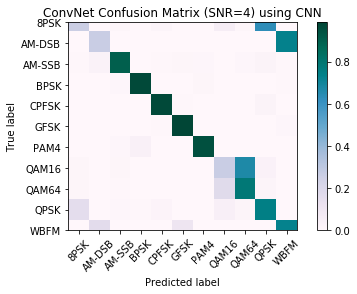

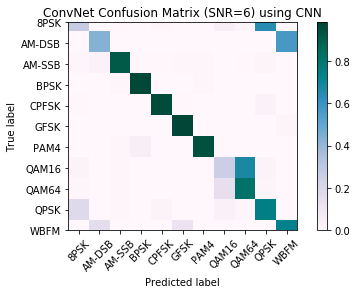

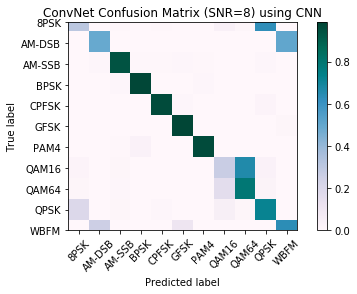

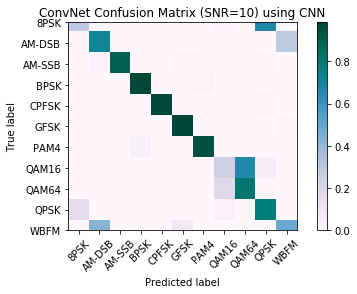

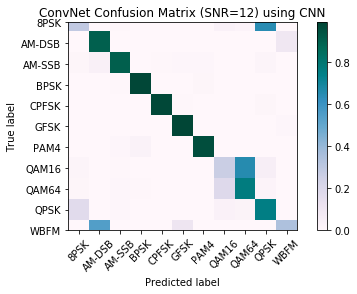

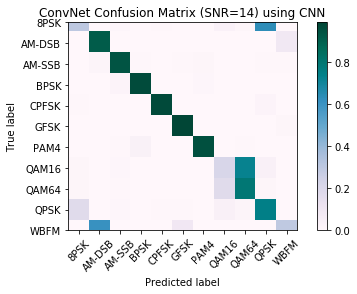

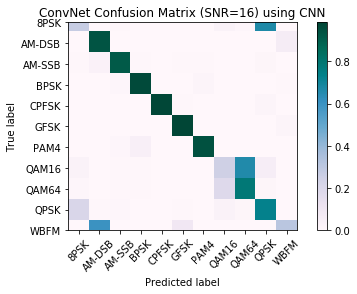

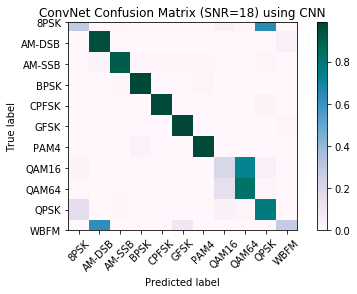

In [15]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i,batch_size=1024)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix SNR=%d using CNN with different features"%(snr))
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor

    print("snr",snr)
    print ("Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN Classification Accuracy on dataset RadioML 2016.10 Alpha with different feature')

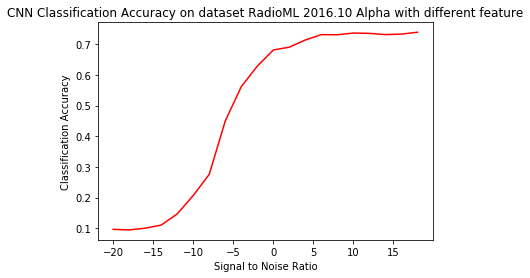

In [16]:
plt.plot(snrs, list(map(lambda x: acc[x], snrs)),color='red')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN Classification Accuracy on dataset RadioML 2016.10 Alpha with different feature")

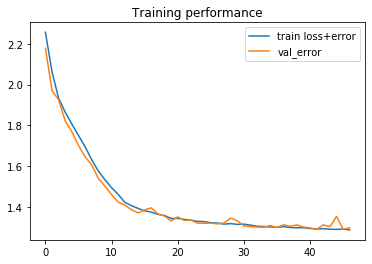

In [17]:
#loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()